# Simple neural network 
In this notebook, a simple neural network based on the melanoma dataset will be build in order to assess initial performance.
The notebook works with data previously saved to the disk (see script: data preparation).

The script that should be performed before this is the script: data_preparation.ipynb

## 1. Imports
In the first step, all necessary libaries will be imported. 

In [1]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

import sklearn # for model evaluation
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import cv2 # for ingesting images
import matplotlib 
import matplotlib.pyplot as plt # for showing images

import sys
import os

## 2. Load and Transform Train Data
In the second step the data will be loaded and transformed. 
This includes the following steps:
- Resizing images
- Flattening images
- Standardizing images
- Combining meta data and images

### Preprocess images

In [2]:
data_partition = "train"
img_location = "data/" + data_partition
ground_truth_location = "data/ISIC_2020_Training_GroundTruth_v2_" + data_partition + ".csv"

# Get list of all file names
image_paths = []
for image in list(os.listdir(img_location)):
    image_paths = image_paths+[img_location+"/"+image]

# Load images into array
img_data = []
for img in image_paths:
    image = cv2.imread(img)[:,:,::-1] # read img and convert the BGR image to RGB
    image = cv2.resize(image, (128, 128)) # resize to be a fixed 128x128 pixels, ignoring original aspect ratio
    img_data.append(image) 
print("Shape of original images", np.array(img_data).shape)

# Flatten images
img_data_flattened = []
for img in img_data:
    img_data_flattened.append(img.flatten()) 
    
# Convert image data to numpy array 
img_data_flattened = np.array(img_data_flattened) / 255
print("Shape of flattened images", np.array(img_data_flattened).shape)

Shape of original images (120, 128, 128, 3)
Shape of flattened images (120, 49152)


### Display original images

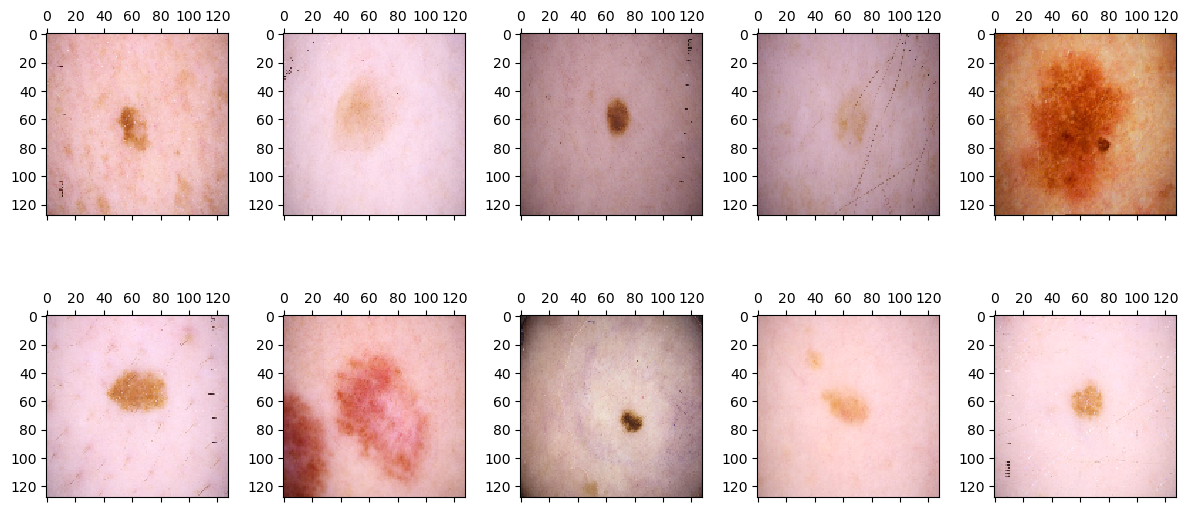

In [3]:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(img_data[n])
        n=n+1
plt.show() 

### Unflatten images and display

Shape of original images (120, 128, 128, 3)
Shape of flattened images (120, 49152)
Shape of unflattened images (120, 128, 128, 3)


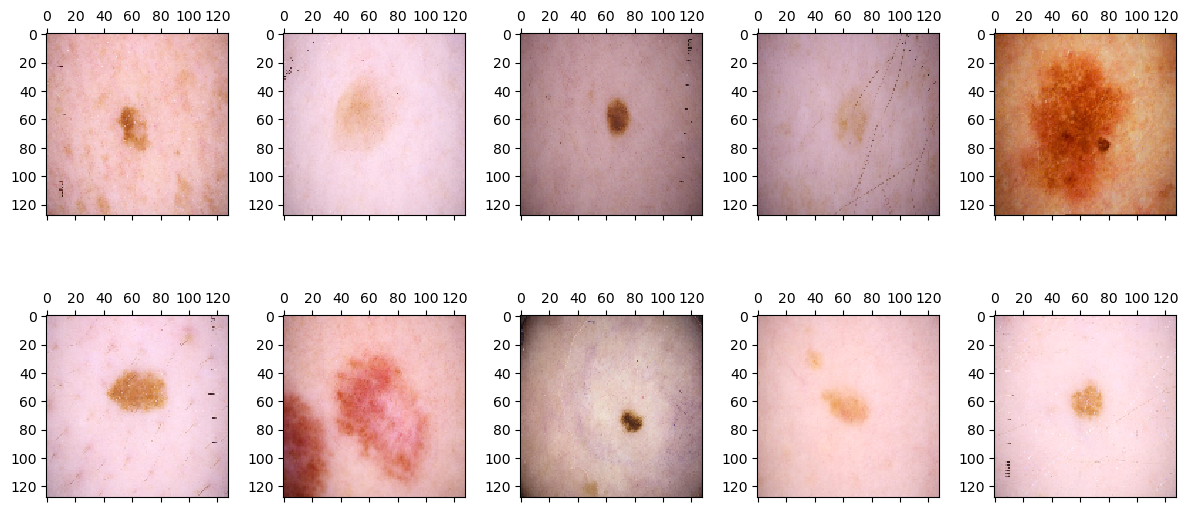

In [4]:
# unflatten
original_data = np.array(img_data)
old_shape = original_data.shape
print("Shape of original images", old_shape)
print("Shape of flattened images", img_data_flattened.shape)
img_unflattened = img_data_flattened.reshape(old_shape)
print("Shape of unflattened images", img_unflattened.shape)

# display result
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(img_unflattened[n])
        n=n+1
plt.show() 

### Convert to dataframes

In [5]:
# Load img data into data frame
df_img_flattened = pd.DataFrame(img_data_flattened, dtype="float", columns = ['pixel' + str(i + 1) 
                                                             for i in range(img_data_flattened.shape[1])])
df_img_names = pd.DataFrame(image_paths, dtype="string", columns = ["image_name"])
df_img = pd.concat([df_img_flattened, df_img_names], axis=1)

# Load ground truth 
df_ground_truth = pd.read_csv(ground_truth_location)

# Combine img data and ground truth
df_ground_truth.set_index("image_name")
print("Shape of df_ground_truth", df_ground_truth.shape)
df_img.set_index("image_name")
print("Shape of df_img", df_img.shape)
df = pd.merge(df_img, df_ground_truth, how='inner', left_index=True, right_index=True)
print("Shape of df", df.shape)

# Split off target of ground truth
X = df.drop(columns = ['diagnosis', 'benign_malignant', 'target']).copy()
y = df['target']

print("Shape of X", X.shape)
print("Shape of Y", y.shape)

# Exclude non-numeric data types
X = X.select_dtypes(exclude=['object', 'string'])

Shape of df_ground_truth (26160, 11)
Shape of df_img (120, 49153)
Shape of df (120, 49164)
Shape of X (120, 49161)
Shape of Y (120,)


## 3. Load Test Data
In the next step the test data shall be loaded. Since I dont have that data on my pc right now, I just split off a part of my train data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 4. MLP Classifier
Finally, a simple model will be trained and evaluated.
We can see that the model reaches a high accuracy and recall for the images not classified as cancer, however does not identify any image labeled as cancer correctly.This is due to the very low percentage of training samples that are labeled as melanoma=true

In [7]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=42)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

report = classification_report(y_test, y_pred_mlp, digits=4)
print(f'\nClassification_report=\n{report}')


Classification_report=
              precision    recall  f1-score   support

           0     0.9667    1.0000    0.9831        29
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9667        30
   macro avg     0.4833    0.5000    0.4915        30
weighted avg     0.9344    0.9667    0.9503        30



C:\Users\apfel\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apfel\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apfel\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. Displaying results visually

### Unflatten images

In [8]:
old_shape = np.array(img_data).shape
X_test_img = df.filter(regex='pixel*', axis=1) # only get pixel columns

# convert back into original state
images = X_test_img.to_numpy() # * 255 
images = images.reshape(old_shape)

### Display result

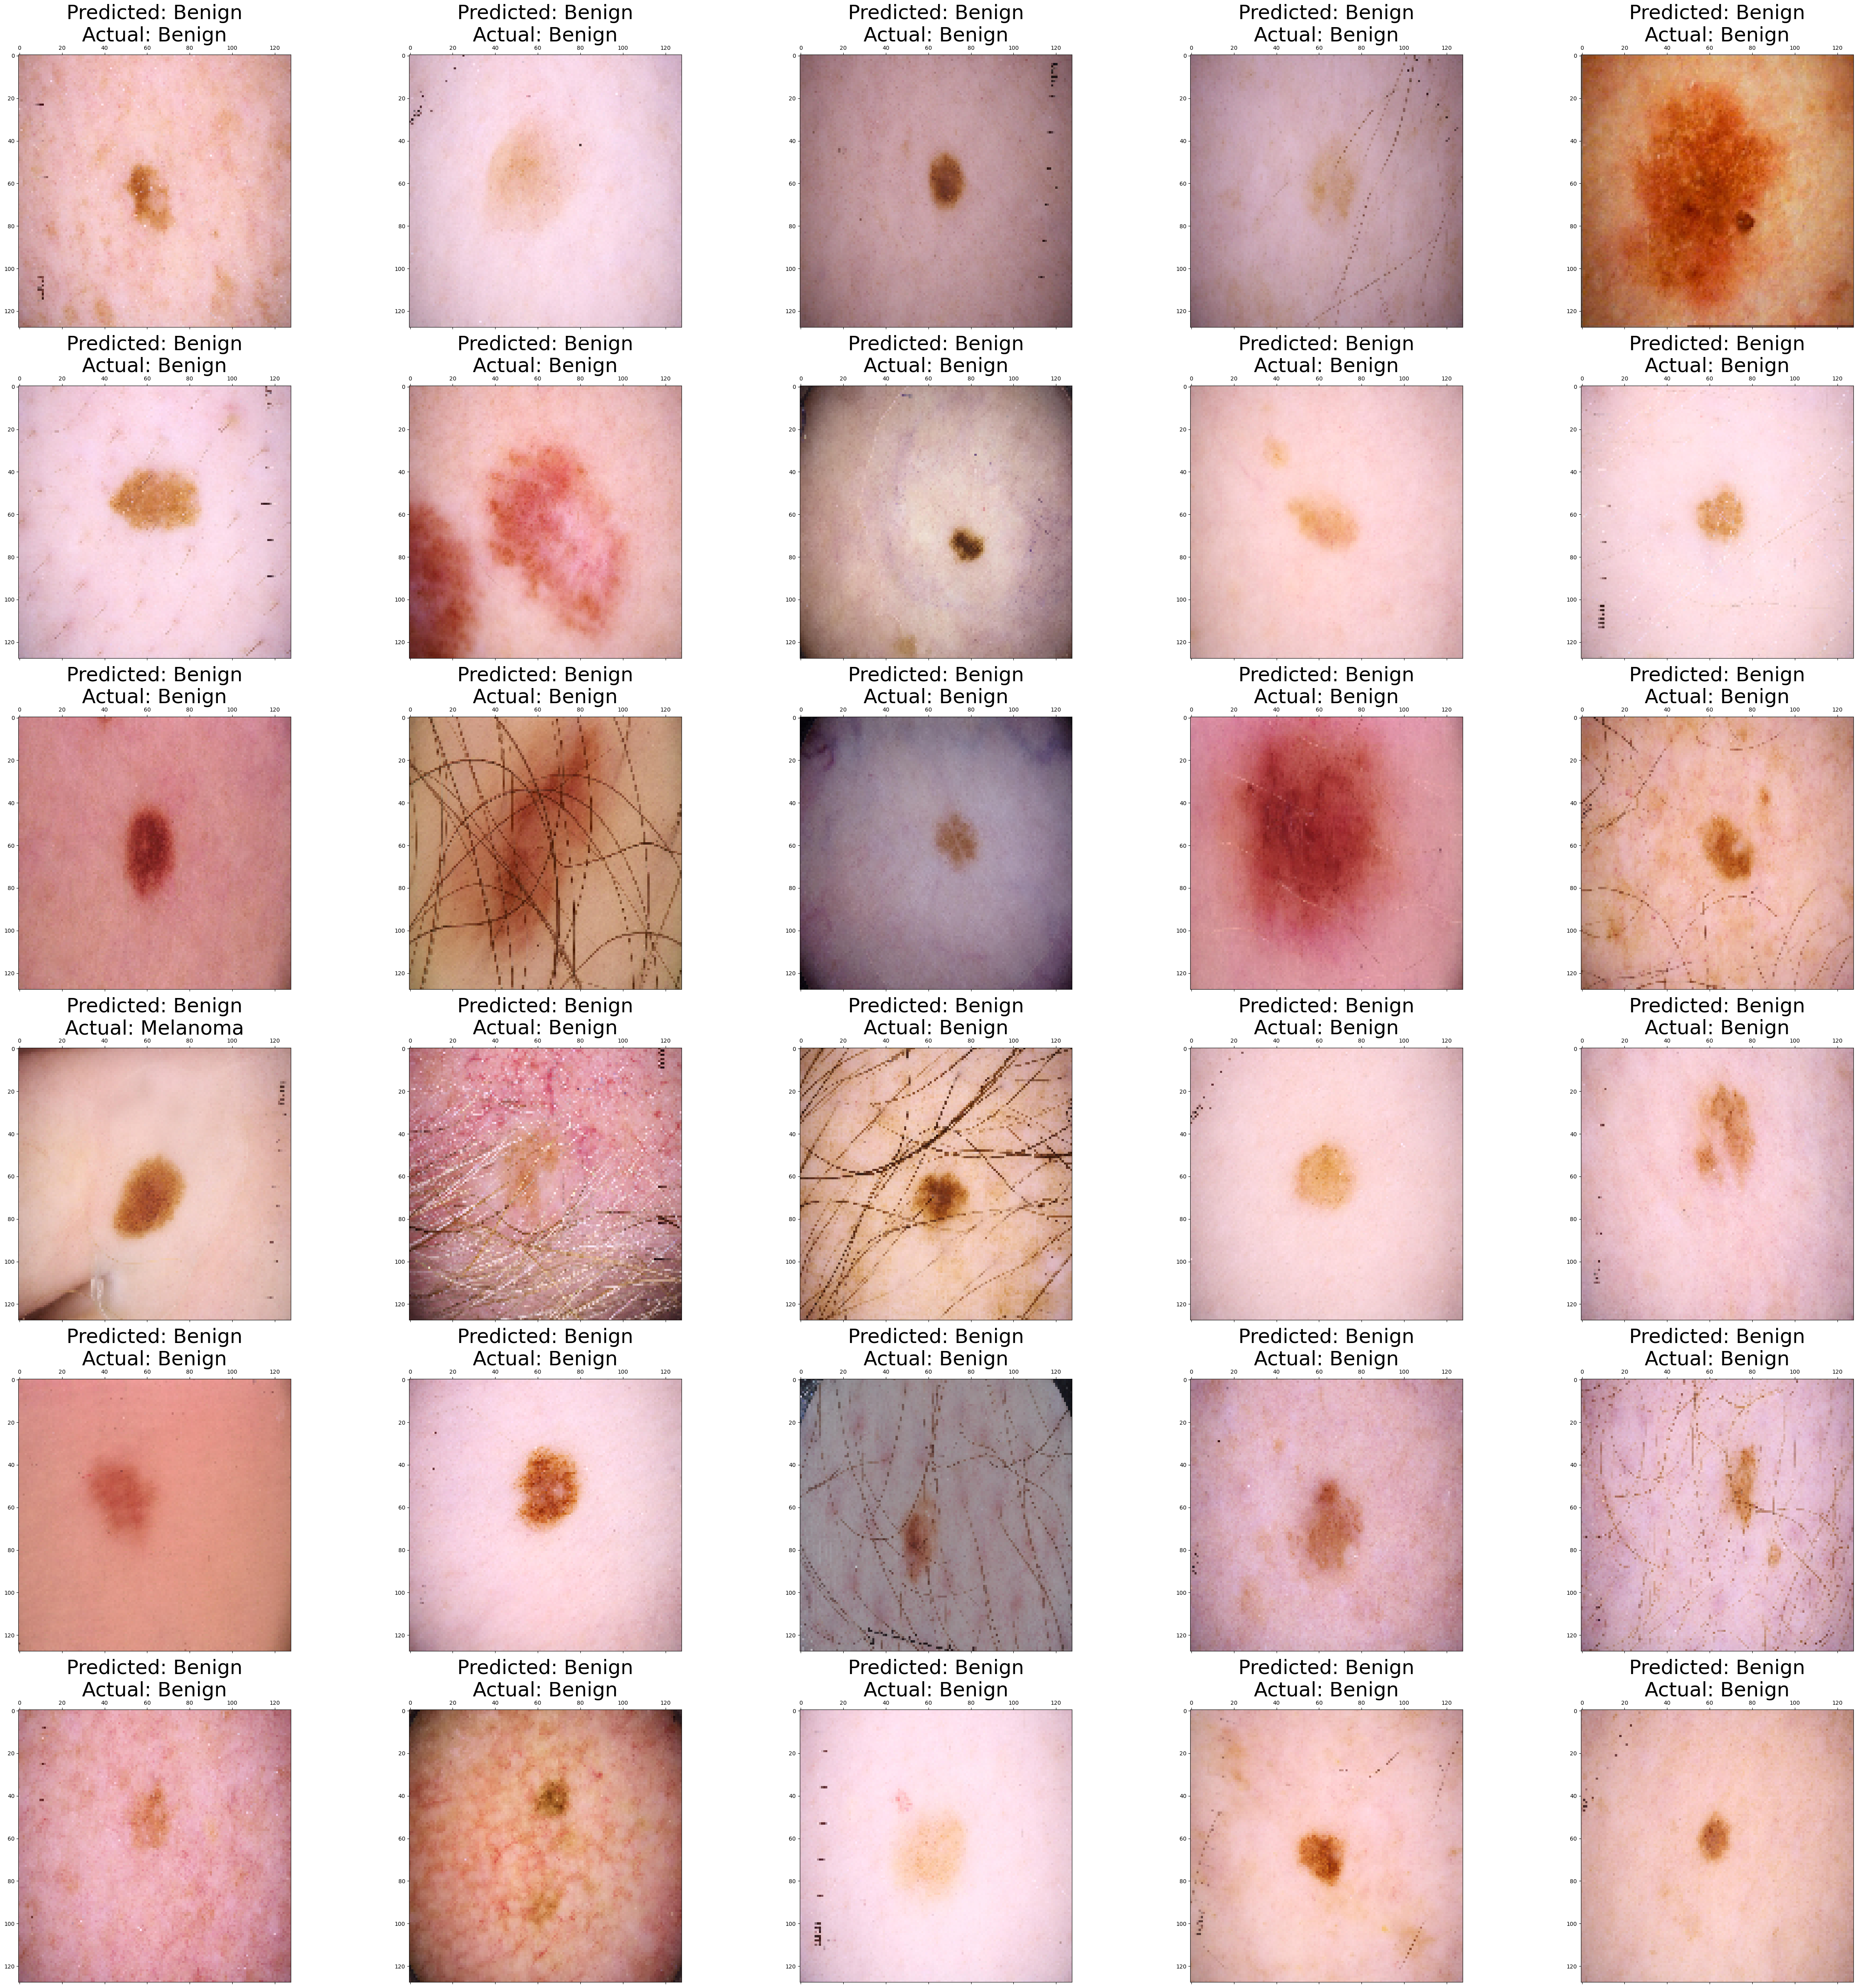

In [12]:
y_test_pred_list = list(y_pred_mlp)
y_test_list = list(y_test)

cols = 5
rows = int(len(y_test_pred_list) / cols)

fig, axs = plt.subplots(rows, cols, sharey=False, tight_layout=True, figsize=(50,50), facecolor='white')
n=0
for i in range(0,rows):
    for j in range(0,cols):
        axs[i,j].matshow(images[n])
        title = "Predicted: " + ("Benign" if y_test_pred_list[n] == 0  else "Melanoma") + "\nActual: " + ("Benign" if y_test_list[n] == 0  else "Melanoma")
        axs[i,j].set_title(title, size = 36)
        n=n+1
plt.show() 